In [1]:
# Import all the required libraries
import fastf1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [2]:
import fastf1
import numpy
import pandas
import matplotlib
import seaborn
import xgboost
import sklearn
import streamlit

print("fastf1:", fastf1.__version__)
print("numpy:", numpy.__version__)
print("pandas:", pandas.__version__)
print("matplotlib:", matplotlib.__version__)
print("seaborn:", seaborn.__version__)
print("xgboost:", xgboost.__version__)
print("scikit-learn:", sklearn.__version__)
print("streamlit:", streamlit.__version__)

fastf1: 3.6.1
numpy: 1.26.4
pandas: 2.2.3
matplotlib: 3.10.0
seaborn: 0.13.2
xgboost: 3.0.0
scikit-learn: 1.6.1
streamlit: 1.37.1


In [3]:
final_df = pd.read_csv('model/DATA/f1_final_data.csv')
final_df

,Round,Abbreviation,GridPosition,Position,Points,FullName,TeamId,AvgQualiPosition,AvgRacePosition,QualifyingScore
0,1,VER,1.0,1.0,738.0,Max Verstappen,red_bull,3.630435,3.760870,2.315217
1,1,SAI,4.0,3.0,301.0,Carlos Sainz,williams,8.444444,9.044444,6.222222
2,1,LEC,2.0,4.0,536.0,Charles Leclerc,ferrari,5.326087,5.630435,3.663043
3,1,RUS,3.0,5.0,497.0,George Russell,mercedes,5.043478,5.652174,4.021739
4,1,NOR,7.0,6.0,711.0,Lando Norris,mclaren,3.217391,4.304348,5.108696
...,...,...,...,...,...,...,...,...,...,...
780,22,ALB,16.0,16.0,82.0,Alexander Albon,williams,12.695652,12.760870,14.347826
781,22,BOR,18.0,17.0,19.0,Gabriel Bortoleto,sauber,14.318182,14.454545,16.159091
782,22,STR,12.0,18.0,52.0,Lance Stroll,aston_martin,14.022222,13.533333,13.011111
783,22,NOR,1.0,19.0,711.0,Lando Norris,mclaren,3.217391,4.304348,2.108696


In [4]:
# Select only numerical columns from final_df for visualization or modeling
df_plot = final_df.select_dtypes(include='number')

<Axes: >

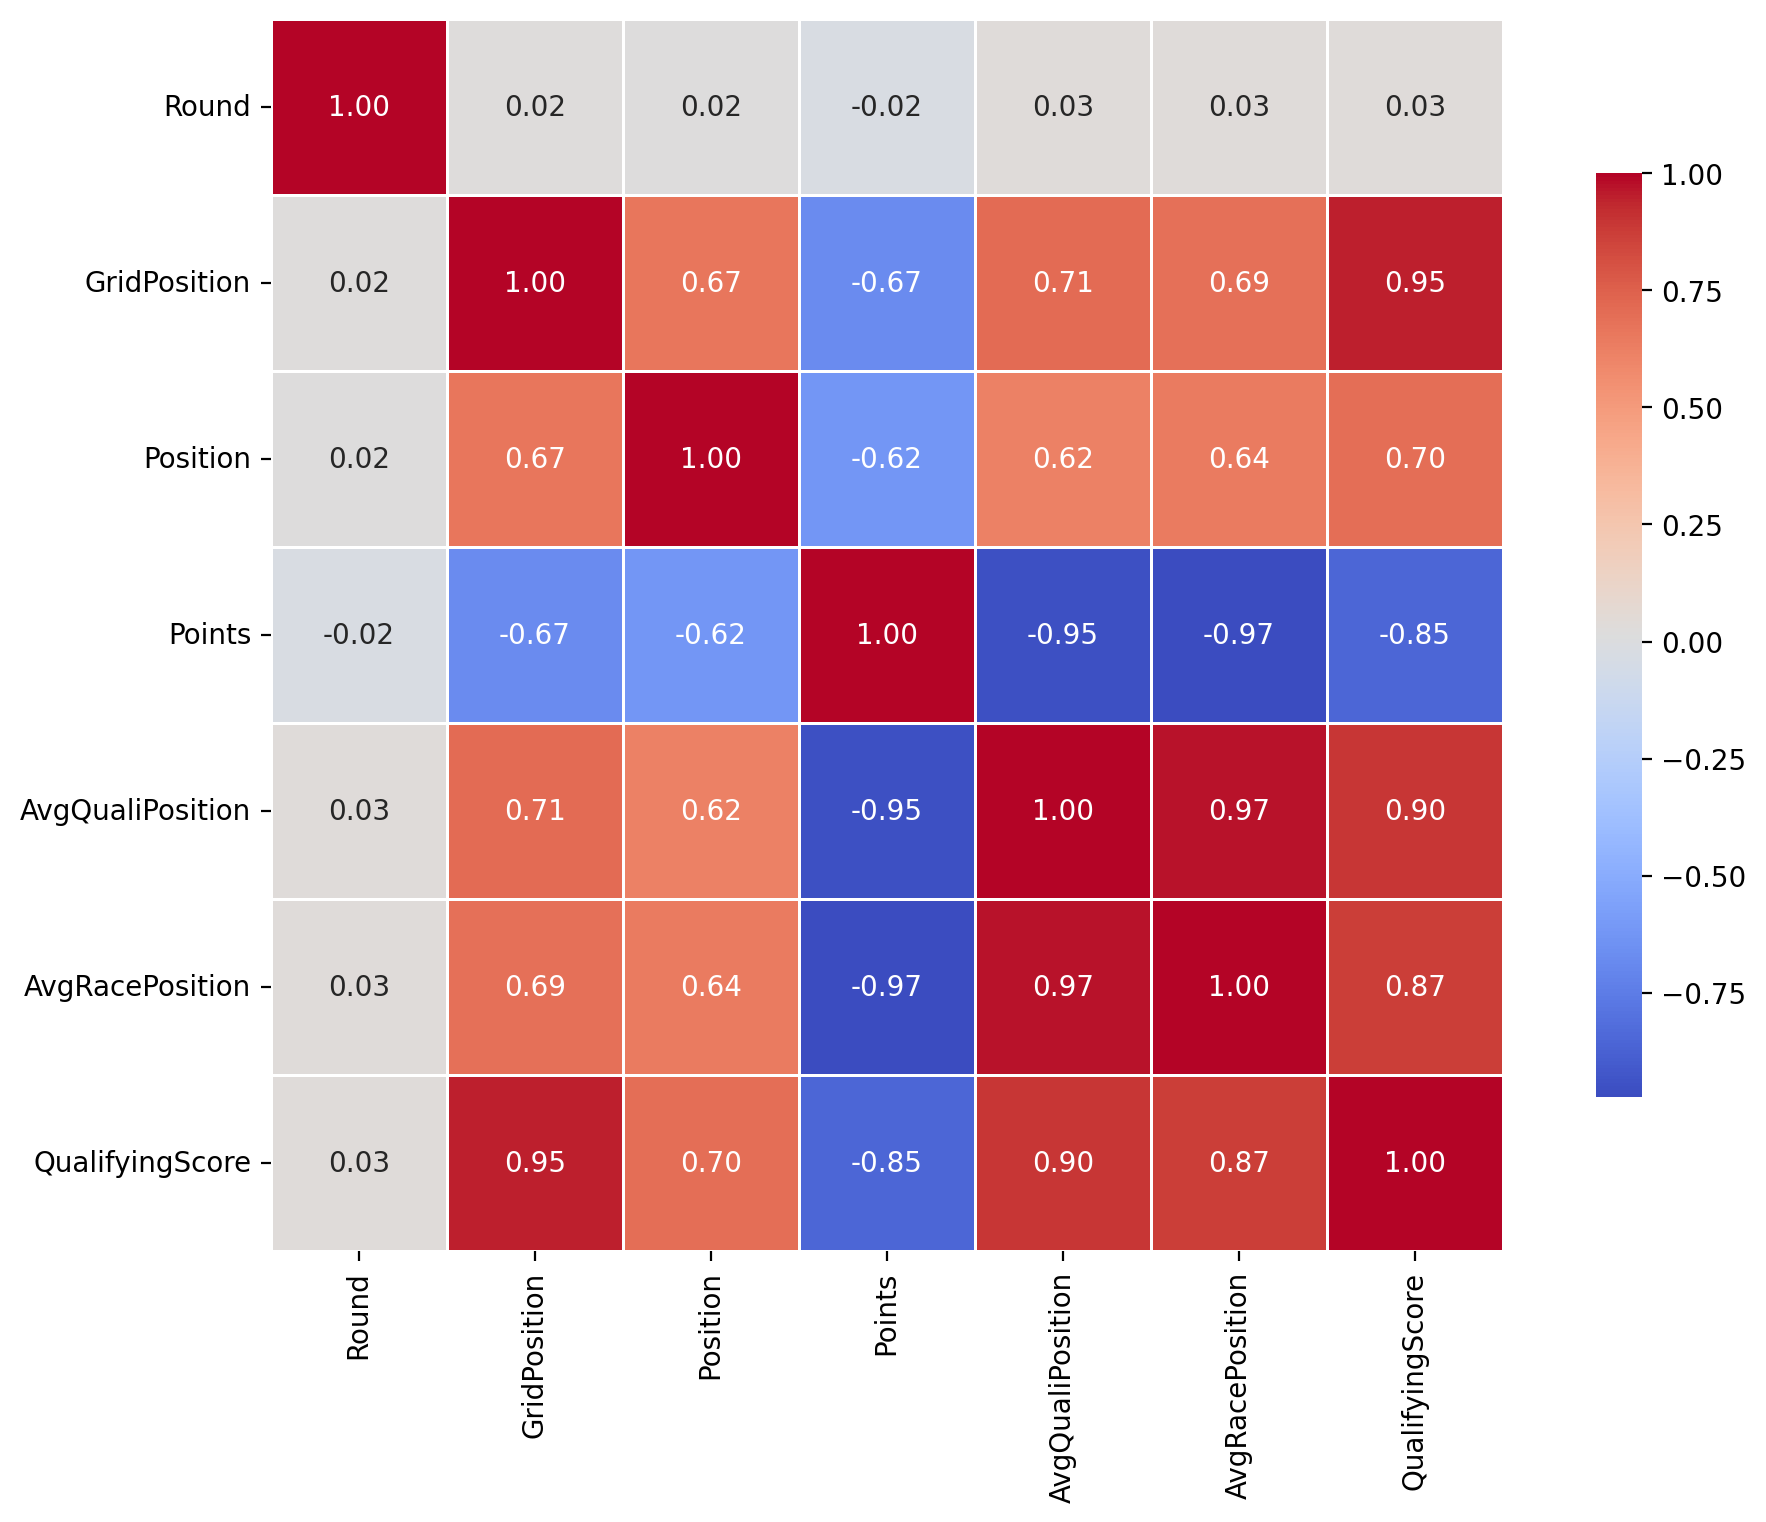

In [5]:
# Set figure size for better visibility
plt.figure(figsize=(12, 8), dpi=200)

# Create a heatmap to visualize correlations between numerical features
sns.heatmap(df_plot.corr(), annot=True, cmap="coolwarm", fmt=".2f", 
            linewidths=1, square=True, cbar_kws={"shrink": 0.75})

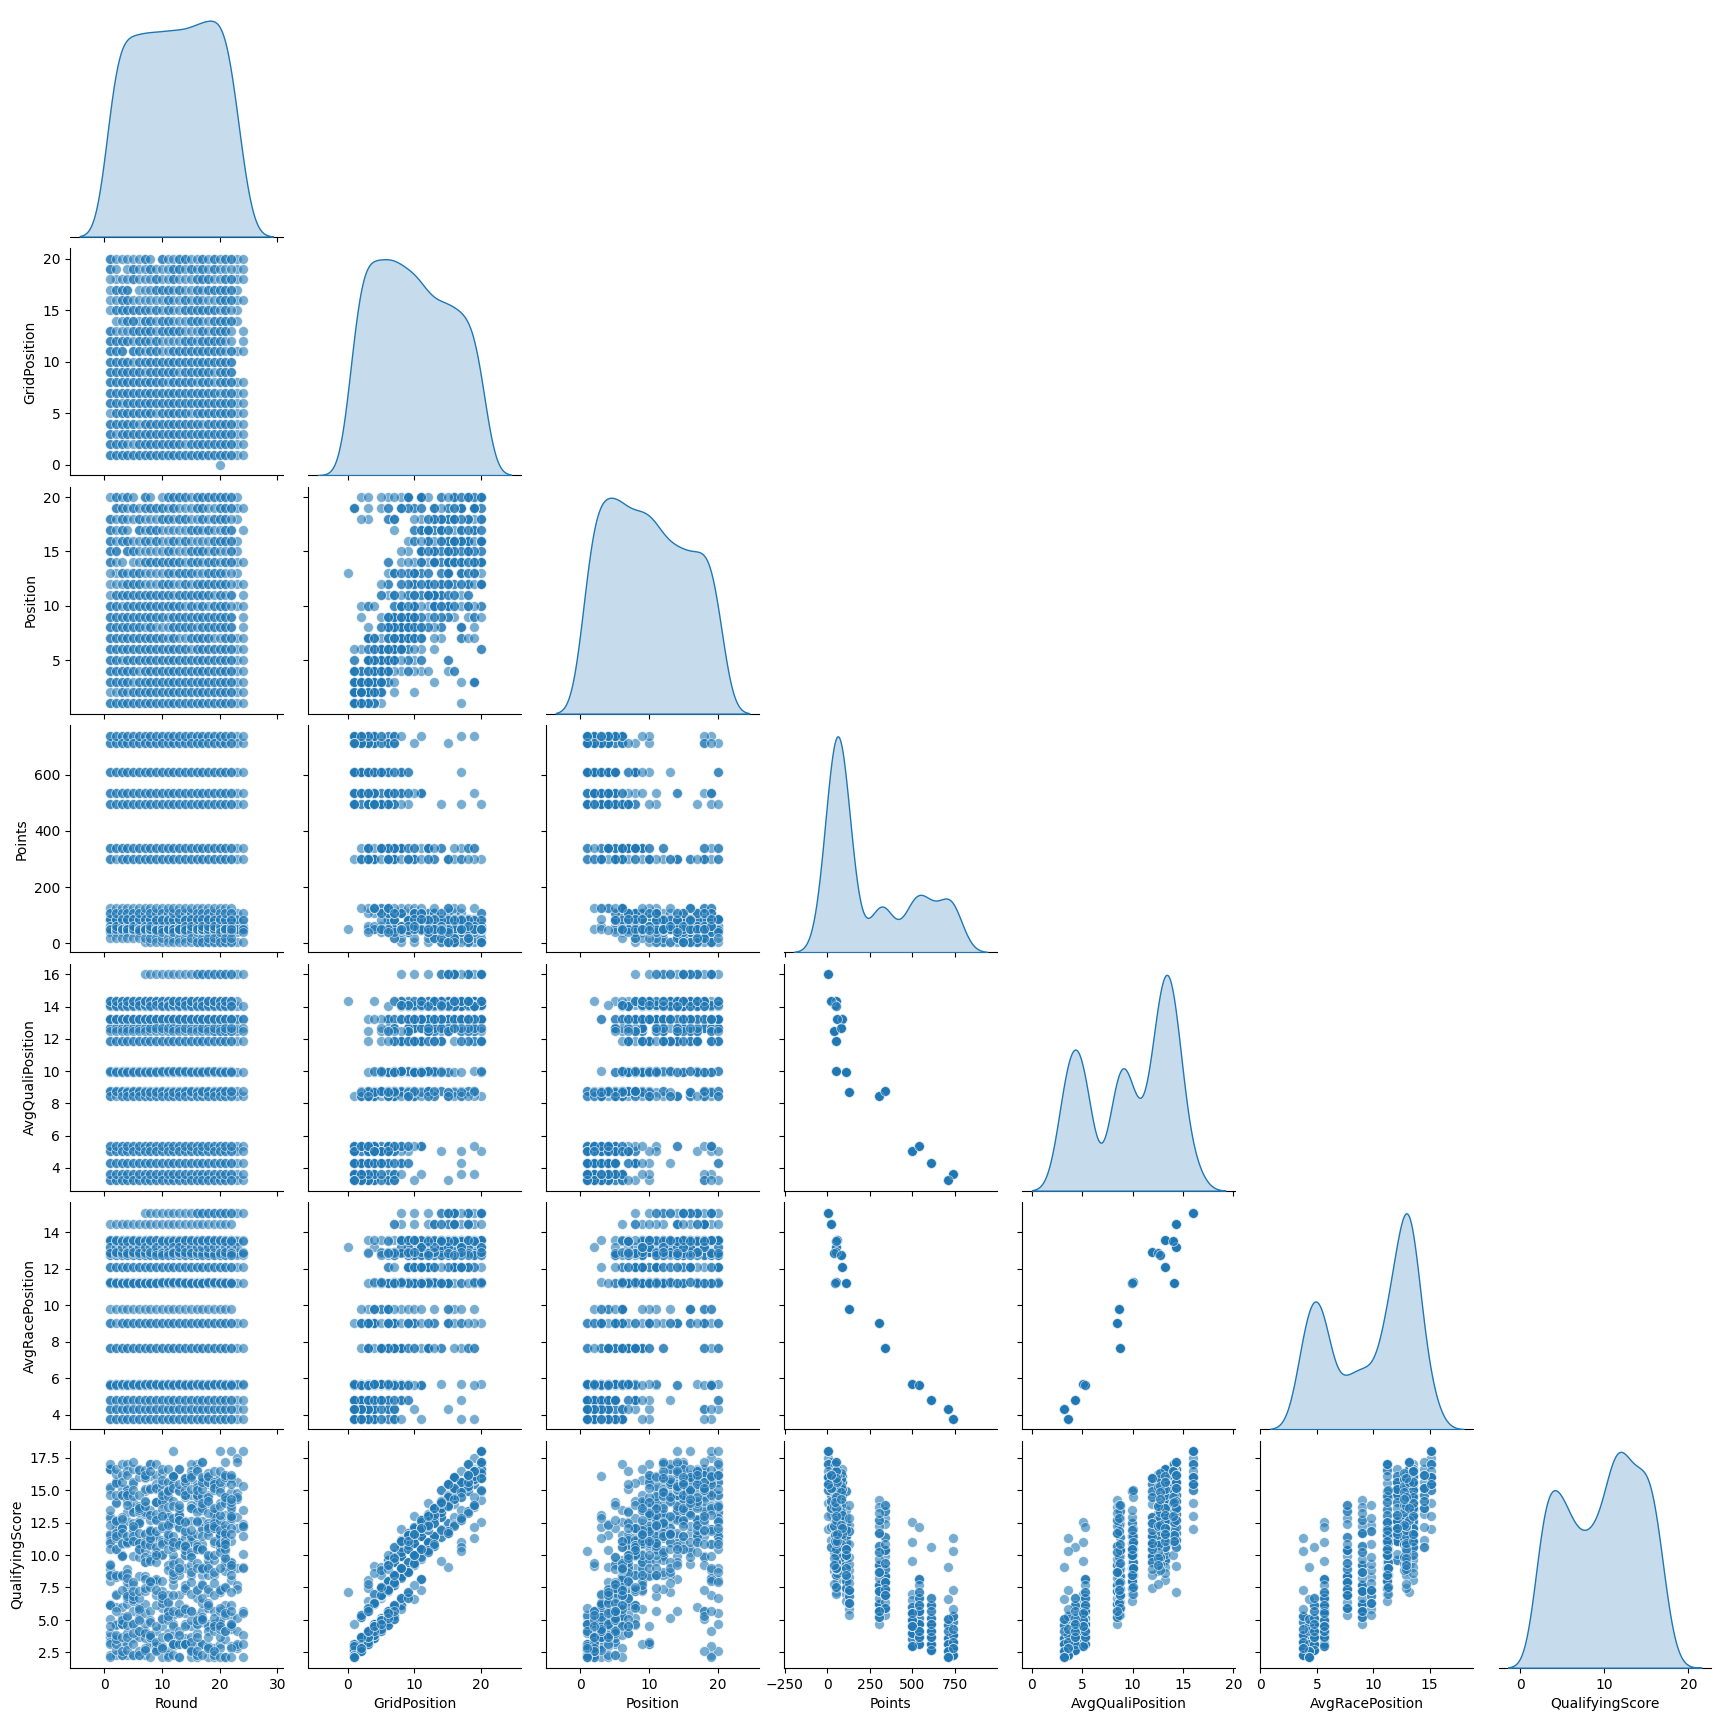

In [6]:
# Generate a pairplot to explore relationships between numerical variables
# - 'diag_kind="kde"' creates kernel density estimates on the diagonal
# - 'corner=True' avoids duplicate plots
# - 'plot_kws' adjusts the appearance of scatter plots
sns.pairplot(df_plot, diag_kind="kde", corner=True, plot_kws={'alpha': 0.6, 's': 50})
plt.show()

In [7]:
final_df = final_df.drop(['FullName','TeamId'] ,axis=1)
final_df

,Round,Abbreviation,GridPosition,Position,Points,AvgQualiPosition,AvgRacePosition,QualifyingScore
0,1,VER,1.0,1.0,738.0,3.630435,3.760870,2.315217
1,1,SAI,4.0,3.0,301.0,8.444444,9.044444,6.222222
2,1,LEC,2.0,4.0,536.0,5.326087,5.630435,3.663043
3,1,RUS,3.0,5.0,497.0,5.043478,5.652174,4.021739
4,1,NOR,7.0,6.0,711.0,3.217391,4.304348,5.108696
...,...,...,...,...,...,...,...,...
780,22,ALB,16.0,16.0,82.0,12.695652,12.760870,14.347826
781,22,BOR,18.0,17.0,19.0,14.318182,14.454545,16.159091
782,22,STR,12.0,18.0,52.0,14.022222,13.533333,13.011111
783,22,NOR,1.0,19.0,711.0,3.217391,4.304348,2.108696


In [8]:
# Create new column for tier label
def position_tier(pos):
    if pos <= 5:
        return 0  # Top Tier
    elif pos <= 10:
        return 1  # Midfield
    else:
        return 2  # Backmarker

In [9]:
# Apply to target column
final_df["PositionTier"] = final_df["Position"].apply(position_tier)

In [10]:
final_df

,Round,Abbreviation,GridPosition,Position,Points,AvgQualiPosition,AvgRacePosition,QualifyingScore,PositionTier
0,1,VER,1.0,1.0,738.0,3.630435,3.760870,2.315217,0
1,1,SAI,4.0,3.0,301.0,8.444444,9.044444,6.222222,0
2,1,LEC,2.0,4.0,536.0,5.326087,5.630435,3.663043,0
3,1,RUS,3.0,5.0,497.0,5.043478,5.652174,4.021739,0
4,1,NOR,7.0,6.0,711.0,3.217391,4.304348,5.108696,1
...,...,...,...,...,...,...,...,...,...
780,22,ALB,16.0,16.0,82.0,12.695652,12.760870,14.347826,2
781,22,BOR,18.0,17.0,19.0,14.318182,14.454545,16.159091,2
782,22,STR,12.0,18.0,52.0,14.022222,13.533333,13.011111,2
783,22,NOR,1.0,19.0,711.0,3.217391,4.304348,2.108696,2


In [11]:
# Replace these with your actual feature columns
X = final_df.drop(columns=['Position', 'PositionTier']) 
y = final_df['PositionTier']

label_enc_driver = LabelEncoder()
X["Abbreviation"] = label_enc_driver.fit_transform(X["Abbreviation"])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train

,Round,Abbreviation,GridPosition,Points,AvgQualiPosition,AvgRacePosition,QualifyingScore
443,5,17,16.0,52.0,14.022222,13.533333,15.011111
210,16,11,4.0,536.0,5.326087,5.630435,4.663043
133,10,6,7.0,60.0,13.217391,13.565217,10.108696
741,20,16,12.0,301.0,8.444444,9.044444,10.222222
519,9,16,17.0,301.0,8.444444,9.044444,12.722222
...,...,...,...,...,...,...,...
71,6,19,1.0,738.0,3.630435,3.760870,2.315217
106,8,0,9.0,82.0,12.695652,12.760870,10.847826
270,19,13,12.0,51.0,14.333333,13.177778,13.166667
435,5,16,6.0,301.0,8.444444,9.044444,7.222222


In [13]:
import joblib
feature_columns = X_train.columns.tolist()
joblib.dump(feature_columns, "model/feature_columns.pkl")

['model/feature_columns.pkl']

In [14]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save it
joblib.dump(scaler, "model/scaler.pkl")

['model/scaler.pkl']

In [15]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [16]:
import dagshub
import mlflow
# Initialize Dagshub for MLflow tracking
dagshub.init(repo_owner="tauqeerahson07", repo_name="Formula-1-race-prediction", mlflow=True)

print("Tracking URI:", mlflow.get_tracking_uri())


Accessing as tauqeerahson07

Initialized MLflow to track repo "tauqeerahson07/Formula-1-race-prediction"

Repository tauqeerahson07/Formula-1-race-prediction initialized!

Tracking URI: https://dagshub.com/tauqeerahson07/Formula-1-race-prediction.mlflow


In [20]:
import mlflow
import mlflow.sklearn

# Set the MLflow experiment
mlflow.set_experiment("f1_race_prediction")


with mlflow.start_run(run_name="f1_race_stacking_model"):
    # Log parameters
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 4, 5],
        'min_samples_split': [2, 5, 7],
        'min_samples_leaf': [1, 3, 5]
    }
    mlflow.log_param("param_grid", param_grid)

    # Train GradientBoostingRegressor with GridSearchCV
    gbr = GradientBoostingRegressor(random_state=42)
    grid = GridSearchCV(gbr, param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_gbr = grid.best_estimator_

    # Log the best parameters
    mlflow.log_params(grid.best_params_)

    # Define base estimators
    estimators = [
        ('ridge', Ridge(alpha=1.0)),
        ('lasso', Lasso(alpha=0.01)),
        ('xgb',XGBRegressor(n_estimators=200, verbosity=1, tree_method="hist", device="cuda")),
        ('gbr', best_gbr)
    ]

    # Define stacking regressor
    stack = StackingRegressor(estimators=estimators, final_estimator=Ridge())

    # Train the stacking model
    stack.fit(X_train, y_train)

    # Make predictions
    y_pred = stack.predict(X_test)

    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Log metrics
    mlflow.log_metric("r2_score", r2)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("rmse", rmse)

    # Save and log the model
    joblib.dump(stack, "model/f1_race_predictor_model.pkl")
    
    input_example = X_test[:5]  # Example input data
    mlflow.sklearn.log_model(stack, "model", input_example=input_example)

    # Persist URIs for registration
    model_uri = mlflow.get_artifact_uri("model")
    run_id = mlflow.active_run().info.run_id

    # Print results
    print("\n" + "="*50)
    print("Training completed!")
    print(f"R2 Score: {r2:.4f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MLflow Run ID: {run_id}")
    print(f"Model URI: {model_uri}")
    print("="*50)

c:\Users\Tauqeer Ahson\OneDrive\Desktop\uni\Semester 9\MLOPS\project\Formula-1-race-prediction\f1_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025/11/29 17:52:06 INFO mlflow.models.model: Found the following environment variables used during model inference: [OPENAI_API_KEY]. Please check if you need to set them when deploying the model. To disable this message, set environment variable `MLFLOW_RECORD_ENV_VARS_IN_MODEL_LOGGING` to `false`.



Training completed!
R2 Score: 0.6236
MAE: 0.39
RMSE: 0.50
MLflow Run ID: ce0bedeedf174ec5a3f4b13814a33cc2
Model URI: mlflow-artifacts:/f68680ba8d124bbf94330a7696297d4e/ce0bedeedf174ec5a3f4b13814a33cc2/artifacts/model
🏃 View run f1_race_stacking_model at: https://dagshub.com/tauqeerahson07/Formula-1-race-prediction.mlflow/#/experiments/0/runs/ce0bedeedf174ec5a3f4b13814a33cc2
🧪 View experiment at: https://dagshub.com/tauqeerahson07/Formula-1-race-prediction.mlflow/#/experiments/0
